In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import trange
import random

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Layer, Activation, Dense, Embedding, Bidirectional, GRU, LSTM, Concatenate, Dropout, Flatten, RepeatVector, Dense, LeakyReLU, Add, MultiHeadAttention

from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.backend import square, mean
from tensorflow.keras.optimizers import AdamW

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split

from keras_self_attention import SeqSelfAttention

import os

import time
import datetime

In [2]:
# ! pip install keras-self-attention

In [3]:
file_incheon_path = 'Train_mars_Weather.csv'
file_incheon_path2 = 'Test_mars_Weather.csv'

train = pd.read_csv(file_incheon_path)   # UsedPower
test = pd.read_csv(file_incheon_path2) 

In [4]:
# train과 test DataFrame을 병합
data = pd.concat([train, test], ignore_index=True, axis=0).drop_duplicates(subset=['terrestrial_date'])
data = data.drop(columns=['wind_speed'])

In [5]:
# 'terrestrial_date'를 datetime으로 변환
data['terrestrial_date'] = pd.to_datetime(data['terrestrial_date'])

# 날짜 순서대로 정렬 (오름차순으로 정렬)
data = data.sort_values(by='terrestrial_date')

# 모든 날짜 범위를 생성 (2012-08-07 ~ 마지막 날짜)
all_dates = pd.date_range(start=data['terrestrial_date'].min(), end=data['terrestrial_date'].max(), freq='D')

# 기존 데이터에 누락된 날짜만 추가
# 'terrestrial_date'를 기준으로 새로운 데이터프레임 생성 및 누락된 날짜 추가
new_dates = pd.DataFrame(all_dates, columns=['terrestrial_date'])

# 기존 데이터와 누락된 날짜를 병합 (left join)
data = pd.merge(new_dates, data, on='terrestrial_date', how='left')

In [6]:
# 'Month X' 형태의 문자열을 숫자로 변환하는 함수
def convert_month_to_number(month_str):
    if isinstance(month_str, str):  # 문자열일 경우에만 변환
        return int(month_str.split()[1])  # 정수로 변환
    return np.nan  # NaN 또는 숫자형일 경우 NaN 반환

# 'month' 열을 정수형 숫자로 변환
data['month_num'] = data['month'].apply(convert_month_to_number)

# 결측값을 제외한 'month_num'을 정수로 변환
data['month_num'] = data['month_num'].astype('Int64')  # Pandas의 Int64로 변환하여 NaN 값 허용

data['month_num'] = data['month_num'].interpolate(method='linear')
data = data.drop(columns=['month'])
data.rename(columns={'month_num': 'month'}, inplace=True)

In [7]:
data

,terrestrial_date,index,id,sol,ls,min_temp,max_temp,pressure,atmo_opacity,month
0,2012-08-07,1893.0,1.0,1.0,150.0,NaN,NaN,NaN,Sunny,6.0
1,2012-08-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
2,2012-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
3,2012-08-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
4,2012-08-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...
3757,2022-11-20,5.0,3475.0,3658.0,341.0,-71.0,-16.0,798.0,Sunny,12.0
3758,2022-11-21,4.0,3479.0,3659.0,341.0,-72.0,-12.0,798.0,Sunny,12.0
3759,2022-11-22,3.0,3477.0,3660.0,342.0,-72.0,-10.0,798.0,Sunny,12.0
3760,2022-11-23,2.0,3478.0,3661.0,342.0,-73.0,-8.0,797.0,Sunny,12.0


In [8]:
# Reverse the order of the data to go from past to future
data = data.iloc[::-1].reset_index(drop=True)

#결측값 처리
data['min_temp'] = data['min_temp'].interpolate(method='linear')
data['max_temp'] = data['max_temp'].interpolate(method='linear')
data['pressure'] = data['pressure'].interpolate(method='linear')
data['sol'] = data['sol'].interpolate(method='linear')
data['ls'] = data['ls'].interpolate(method='linear')

In [9]:
data

,terrestrial_date,index,id,sol,ls,min_temp,max_temp,pressure,atmo_opacity,month
0,2022-11-24,1.0,3474.0,3662.0,343.000,-72.0,-9.0,800.0,Sunny,12.0
1,2022-11-23,2.0,3478.0,3661.0,342.000,-73.0,-8.0,797.0,Sunny,12.0
2,2022-11-22,3.0,3477.0,3660.0,342.000,-72.0,-10.0,798.0,Sunny,12.0
3,2022-11-21,4.0,3479.0,3659.0,341.000,-72.0,-12.0,798.0,Sunny,12.0
4,2022-11-20,5.0,3475.0,3658.0,341.000,-71.0,-16.0,798.0,Sunny,12.0
...,...,...,...,...,...,...,...,...,...,...
3757,2012-08-11,NaN,NaN,5.0,152.500,-75.0,-16.0,739.0,NaN,6.0
3758,2012-08-10,NaN,NaN,4.0,151.875,-75.0,-16.0,739.0,NaN,6.0
3759,2012-08-09,NaN,NaN,3.0,151.250,-75.0,-16.0,739.0,NaN,6.0
3760,2012-08-08,NaN,NaN,2.0,150.625,-75.0,-16.0,739.0,NaN,6.0


In [10]:
# Reverse the order of the data to go from past to future
data = data.iloc[::-1].reset_index(drop=True)

In [11]:
data

,terrestrial_date,index,id,sol,ls,min_temp,max_temp,pressure,atmo_opacity,month
0,2012-08-07,1893.0,1.0,1.0,150.000,-75.0,-16.0,739.0,Sunny,6.0
1,2012-08-08,NaN,NaN,2.0,150.625,-75.0,-16.0,739.0,NaN,6.0
2,2012-08-09,NaN,NaN,3.0,151.250,-75.0,-16.0,739.0,NaN,6.0
3,2012-08-10,NaN,NaN,4.0,151.875,-75.0,-16.0,739.0,NaN,6.0
4,2012-08-11,NaN,NaN,5.0,152.500,-75.0,-16.0,739.0,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...
3757,2022-11-20,5.0,3475.0,3658.0,341.000,-71.0,-16.0,798.0,Sunny,12.0
3758,2022-11-21,4.0,3479.0,3659.0,341.000,-72.0,-12.0,798.0,Sunny,12.0
3759,2022-11-22,3.0,3477.0,3660.0,342.000,-72.0,-10.0,798.0,Sunny,12.0
3760,2022-11-23,2.0,3478.0,3661.0,342.000,-73.0,-8.0,797.0,Sunny,12.0


In [12]:
# Extract day of year and convert to radians, then to cos values
data['day_of_year'] = data['terrestrial_date'].dt.dayofyear
data['Day_X'] = np.sin(2 * np.pi * data['day_of_year'] / 365.0)
data['Day_Y'] = np.cos(2 * np.pi * data['day_of_year'] / 365.0)


# Drop the original 'terrestrial_date' and 'day_of_year' columns
data = data.drop(columns=['index', 'id', 'terrestrial_date', 'day_of_year', 'atmo_opacity'])

# Reorder columns to place 'Day_X' and 'Day_Y' next to 'index'
columns_order = ['Day_X', 'Day_Y'] + [col for col in data.columns if col not in ['Day_X', 'Day_Y']]
data = data[columns_order]

In [13]:
# 'ls' 변수를 sin과 cos으로 변환
data['ls_sin'] = np.sin(2 * np.pi * data['ls'] / 360.0)
data['ls_cos'] = np.cos(2 * np.pi * data['ls'] / 360.0)

# 'month' 변수를 sin과 cos으로 변환
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12.0)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12.0)

# 원래 'ls'와 'month' 열을 삭제하고 새로운 열을 포함한 데이터프레임으로 갱신
data = data.drop(columns=['ls', 'month'])

In [14]:
# data.to_csv('Combined_Mars12.csv', index = False)

In [15]:
data_copy = data.drop(['min_temp', 'max_temp','pressure'], axis=1)
features = data[['min_temp', 'max_temp','pressure']] 

print(features.shape)

(3762, 3)


In [16]:
data_copy

,Day_X,Day_Y,sol,ls_sin,ls_cos,month_sin,month_cos
0,-0.601624,-0.798779,1.0,0.500000,-0.866025,0.0,-1.0
1,-0.615285,-0.788305,2.0,0.490524,-0.871428,0.0,-1.0
2,-0.628763,-0.777597,3.0,0.480989,-0.876727,0.0,-1.0
3,-0.642055,-0.766659,4.0,0.471397,-0.881921,0.0,-1.0
4,-0.655156,-0.755493,5.0,0.461749,-0.887011,0.0,-1.0
...,...,...,...,...,...,...,...
3757,-0.648630,0.761104,3658.0,-0.325568,0.945519,-0.0,1.0
3758,-0.635432,0.772157,3659.0,-0.325568,0.945519,-0.0,1.0
3759,-0.622047,0.782980,3660.0,-0.309017,0.951057,-0.0,1.0
3760,-0.608477,0.793572,3661.0,-0.309017,0.951057,-0.0,1.0


In [17]:
features

,min_temp,max_temp,pressure
0,-75.0,-16.0,739.0
1,-75.0,-16.0,739.0
2,-75.0,-16.0,739.0
3,-75.0,-16.0,739.0
4,-75.0,-16.0,739.0
...,...,...,...
3757,-71.0,-16.0,798.0
3758,-72.0,-12.0,798.0
3759,-72.0,-10.0,798.0
3760,-73.0,-8.0,797.0


## Data Scaling

In [18]:
min_max_scale  = MinMaxScaler()
scaled_train_x = min_max_scale.fit_transform(data_copy)

print("Min:", np.min(np.array(scaled_train_x)))
print("Max:", np.max(np.array(scaled_train_x)))

Min: 0.0
Max: 1.0


In [19]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

print("Min:", np.min(np.array(scaled_train_x)))
print("Max:", np.max(np.array(scaled_train_x)))

Min: 0.0
Max: 1.0


## Data Spliting

### - 끝~1725까지 테스트, 나머지 트레이닝 

In [20]:
test_origin_x  = scaled_train_x[-1881:]
test_origin_y  = features[-1881:] 

test_x  = scaled_train_x[-1881+1:]
test_y  = features[-1881+1:] 

train_origin_x = scaled_train_x[:len(data_copy)-1881]
train_origin_y = features[:len(data_copy)-1881]

train_x = scaled_train_x[1:len(data_copy)-1881]
train_y = features[1:len(data_copy)-1881]

In [21]:
print("Train data 개수 = {}".format(test_x.shape))
print("Train data 개수 = {}".format(test_y.shape))
print("Train data 개수 = {}".format(train_x.shape))
print("Train data 개수 = {}".format(train_y.shape))
print("Test  data 개수 = {}".format(data_copy.shape[0]))

Train data 개수 = (1880, 7)
Train data 개수 = (1880, 3)
Train data 개수 = (1880, 7)
Train data 개수 = (1880, 3)
Test  data 개수 = 3762


## Reshape into batch size

In [22]:
print(train_x.shape)

def train_batch(train_origin_x, train_origin_y, train_x):
    x_batch_tmp = []
    y_batch_tmp = []

    start   = 1 
    seq     = 1

    for i in range(train_x.shape[0]):
        x_history = train_origin_x[start-seq:start, :]
        y_history = train_origin_y[start-seq:start]

        x_batch_tmp.append(x_history)
        y_batch_tmp.append(y_history)

        start+=1

    x_batch = np.array(x_batch_tmp)
    y_batch = np.array(y_batch_tmp)
    print(x_batch.shape)
    print(y_batch.shape)
    
    return x_batch, y_batch
    
def test_batch(test_origin_x, test_origin_y, test_x):
    x_batch_tmp = []
    y_batch_tmp = []

    start   = 1 
    seq     = 1

    for i in range(test_x.shape[0]):
        x_history = test_origin_x[start-seq:start, :]
        y_history = test_origin_y[start-seq:start]

        x_batch_tmp.append(x_history)
        y_batch_tmp.append(y_history)

        start+=1

    x_batch = np.array(x_batch_tmp)
    y_batch = np.array(y_batch_tmp)
    print(x_batch.shape)
    print(y_batch.shape)   
    
    return x_batch, y_batch

x_batch, y_batch = train_batch(train_origin_x, train_origin_y, train_x)
x_test_batch, y_test_batch = test_batch(test_origin_x, test_origin_y, test_x)


(1880, 7)
(1880, 1, 7)
(1880, 1, 3)
(1880, 1, 7)
(1880, 1, 3)


## Create Model

In [23]:
n_past = 1
n_features = x_batch.shape[2]
n_future = 1
y_feature = y_batch.shape[2]
print(n_features)

7


In [24]:
# model_select = 'bilstm'

In [25]:
# select model

def model_training(model_select, attention, activation):
    # n_features ==> no of features at each timestep in the data.
    encoder_inputs = Input(shape=(n_past, n_features))
    if model_select == 'bilstm':
        with tf.device('/gpu:0'):
            encoder_l1 = Bidirectional(LSTM(14, return_state=True, activation='linear'))  # 'linear'로 설정
            encoder_outputs1, forward_h, forward_c, backward_h, backward_c = encoder_l1(encoder_inputs)
            encoder_states1 = [forward_h, forward_c, backward_h, backward_c]

            decoder_inputs = RepeatVector(n_future)(encoder_outputs1)
            decoder_l1 = Bidirectional(LSTM(14, return_sequences=True, activation='linear'))(decoder_inputs, initial_state=encoder_states1)  # 'linear'로 설정
            decoder_l1 = LeakyReLU(alpha=0.1)(decoder_l1)  # LeakyReLU 활성화 추가
            decoder_l2 = Bidirectional(LSTM(14, return_sequences=True, activation='linear'))(decoder_l1)
            decoder_l2 = LeakyReLU(alpha=0.1)(decoder_l2)  # LeakyReLU 활성화 추가
            decoder_residual = Add()([decoder_l1, decoder_l2])  # Residual 연결

    elif model_select == 'lstm':
        with tf.device('/gpu:0'):
            encoder_l1 = LSTM(14, return_state=True, activation=activation)
            encoder_outputs1 = encoder_l1(encoder_inputs)
            encoder_states1 = encoder_outputs1[1:]
            decoder_inputs = RepeatVector(n_future)(encoder_outputs1[0])
            decoder_l1 = LSTM(14, return_sequences=True, activation=activation)(decoder_inputs, initial_state = encoder_states1)
            decoder_l2 = LSTM(14, return_sequences=True, activation=activation)(decoder_l1)
            decoder_residual = Add()([decoder_l1, decoder_l2])  # Residual 연결
            

    elif model_select == 'gru':
        with tf.device('/gpu:0'):
            encoder_l1 = GRU(14, return_state=True, activation=activation)
            encoder_outputs1 = encoder_l1(encoder_inputs)
            encoder_states1 = encoder_outputs1[1:]
            decoder_inputs = RepeatVector(n_future)(encoder_outputs1[0])
            decoder_l1 = GRU(14, return_sequences=True, activation=activation)(decoder_inputs, initial_state = encoder_states1)
            decoder_l2 = GRU(14, return_sequences=True, activation=activation)(decoder_l1)
            decoder_residual = Add()([decoder_l1, decoder_l2])  # Residual 연결


    elif model_select == 'bigru':  
        with tf.device('/gpu:0'):
            encoder_l1 = Bidirectional(GRU(14, return_state=True, activation=activation))
            encoder_outputs1 = encoder_l1(encoder_inputs)
            encoder_states1 = encoder_outputs1[1:]
            decoder_inputs = RepeatVector(n_future)(encoder_outputs1[0])
            decoder_l1 = Bidirectional(GRU(14, return_sequences=True, activation=activation))(decoder_inputs, initial_state=encoder_states1)
            decoder_l2 = Bidirectional(GRU(14, return_sequences=True, activation=activation))(decoder_l1)
            decoder_residual = Add()([decoder_l1, decoder_l2])  # Residual 연결

    if attention:
        decoder_residual_attention = SeqSelfAttention(attention_activation='relu')(decoder_residual)
        decoder_residual = decoder_residual_attention
    else:
        decoder_residual = decoder_residual
    
    decoder_outputs1 = TimeDistributed(Dense(y_feature, activation='linear'))(decoder_residual)

    model_result = Model(encoder_inputs, decoder_outputs1)

    model_result.summary()

    return model_result

In [26]:
optimizer = optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.Huber()
model = model_training('bilstm', True, LeakyReLU())
model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

# callback - 조기종료
early_stop = keras.callbacks.EarlyStopping(monitor='mae', min_delta = 0, patience=10, restore_best_weights=True)

# random_set 고정
start = time.time()
tf.random.set_seed(42)
model.fit(x_batch, y_batch, batch_size=12, epochs=100, verbose = True, callbacks = [early_stop])
end = time.time()
print('소요시간:', end-start)

c:\Users\PC\anaconda3\envs\jo\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 7)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 28),      │      2,464 │ input_layer[0][0] │
│ (Bidirectional)     │ (None, 14),       │            │                   │
│                     │ (None, 14),       │            │                   │
│                     │ (None, 14),       │            │                   │
│                     │ (None, 14)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 1, 28)     │          0 │ bidirectional[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 1, 28)     │      4,816 │ repeat_vector[0]… │
│ (Bidirectional)     │                   │            │ bidirectional[0]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 1, 28)     │          0 │ bidirectional_1[… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 1, 28)     │      4,816 │ leaky_re_lu_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 1, 28)     │          0 │ bidirectional_2[… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 28)     │          0 │ leaky_re_lu_1[0]… │
│                     │                   │            │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_self_attention  │ (None, 1, 28)     │      1,857 │ add[0][0]         │
│ (SeqSelfAttention)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 1, 3)      │         87 │ seq_self_attenti… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,040 (54.84 KB)

 Trainable params: 14,040 (54.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 306.9954 - mae: 307.4884
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 136.0284 - mae: 136.5242
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 73.3387 - mae: 73.8304
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64.2773 - mae: 64.7683
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 54.1617 - mae: 54.6502
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.0673 - mae: 42.5571
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.6893 - mae: 27.1797
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12.6503 - mae: 13.1375
Epoch 9/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11.3300 - mae: 11.8168
Epoch 10/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.0264 - mae: 11.5137
Epoch 11/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.7258 - mae: 11.2138
Epoch 12/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.4005 

In [27]:
tf.random.set_seed(42)

In [28]:
#bilstm_history = model.fit(x_batch, y_batch, batch_size=11, epochs=50)

In [29]:
# tf.keras.models.model.save("incheon_bilstm_selu_att.h5")
# load_m = tf.keras.models.load_model("incheon_bilstm_selu_att.h5")

In [30]:
mae_pred = model.predict(x_test_batch)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [31]:
y_test_batch.shape

(1880, 1, 3)

In [32]:
mae_pred_re = mae_pred.reshape(x_test_batch.shape[0], -1)
y_test_batch_re = y_test_batch.reshape(y_test_batch.shape[0], -1)

print(mae_pred_re.shape)
print(y_test_batch_re.shape)

(1880, 3)
(1880, 3)


In [33]:
mae_result = mean_absolute_error(mae_pred_re, y_test_batch_re)
mse_result = mean_squared_error(mae_pred_re, y_test_batch_re)
rmse_result = (mse_result)**0.5

print("MAE = {}".format((mae_result)))
print("MSE = {}".format(mse_result))
print("RMSE = {}".format(rmse_result))

rmse_11_points = []

def mae_11_points(pred, y):
    mae_11_points = []

    for i in range(pred.shape[1]):
        mae_point = np.mean(np.abs(pred[:,i] - y[:, i]))
        mae_11_points.append(mae_point)

    return mae_11_points

def rmse_11_points(pred, y):
    rmse_11 = []
    
    for i in range(pred.shape[1]):
        rmse_point = np.sqrt(np.mean(np.square(pred[:,i]-y[:,i])))
        rmse_11.append(rmse_point)
        
    return rmse_11
    
mae_11 = np.round(mae_11_points(mae_pred_re, y_test_batch_re), 6)
rmse_11 = np.round(rmse_11_points(mae_pred_re, y_test_batch_re), 6)

print(mae_11)
print(rmse_11)

MAE = 10.751326102331292
MSE = 284.0241725473125
RMSE = 16.853016719487123
[ 4.269578  5.623999 22.360402]
[ 5.379322  8.037612 27.541463]


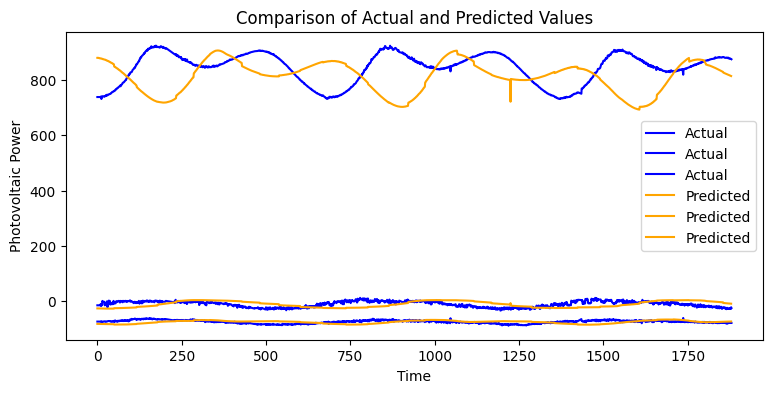

In [34]:
import matplotlib.pyplot as plt

# 실제 값과 예측 값을 그래프로 표현
plt.figure(figsize=(9, 4))
plt.plot(train_origin_y, label='Actual', color='blue')
plt.plot(mae_pred_re, label='Predicted', color='orange')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Time')
plt.ylabel('Photovoltaic Power')
plt.legend()
plt.show()

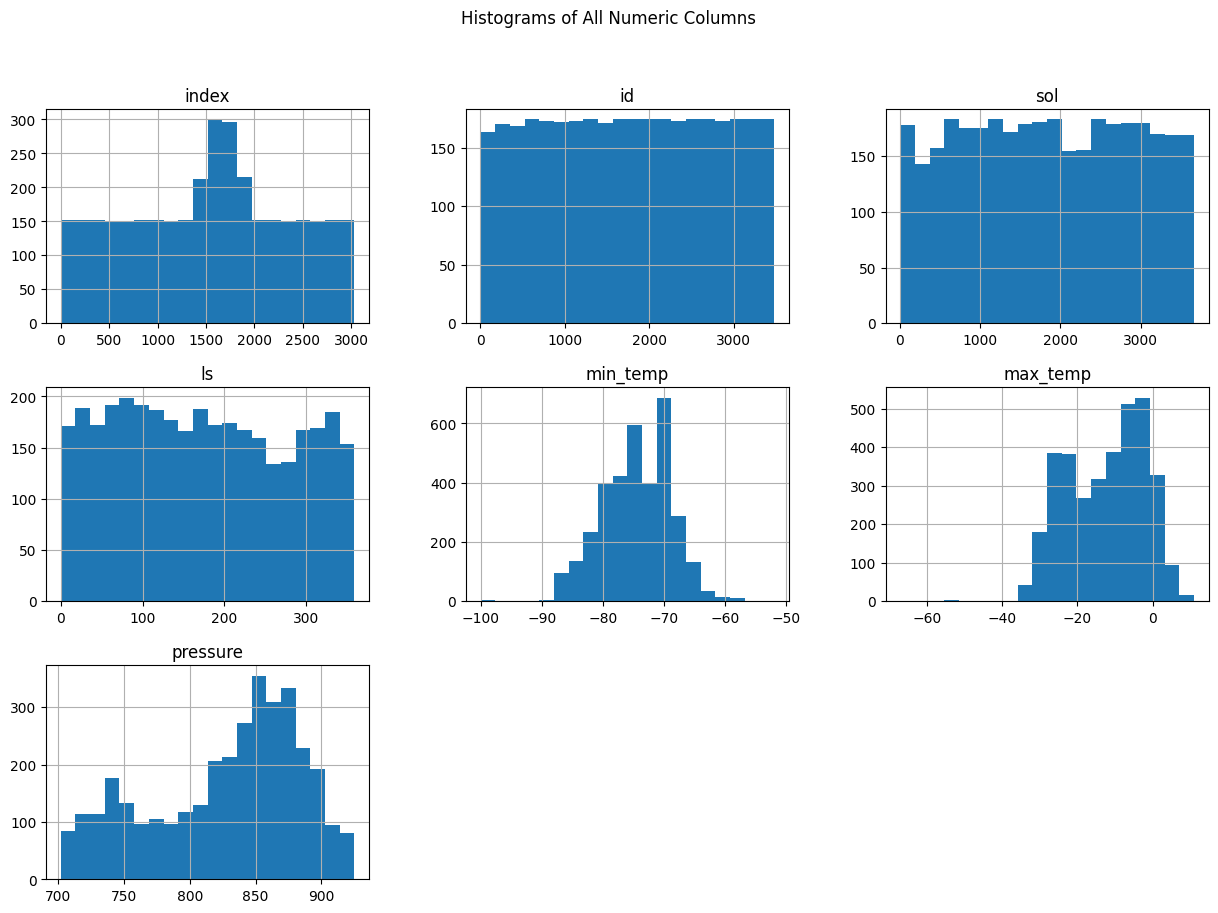

In [ ]:
# 히스토그램 생성
data.hist(bins=20, figsize=(15, 10))
plt.suptitle('Histograms of All Numeric Columns')
plt.show()